## Painting Classifier by Style

### Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

### Loading in the data

In [2]:
df = pd.read_csv("/Users/aryan/Downloads/all_data_info.csv")
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


In [3]:
df["style"].value_counts()

Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: style, Length: 136, dtype: int64

Artist: Claude Monet, Title: The Banks of the Seine at the Argenteuil Bridge, Style: Impressionism
File name: 13628.jpg


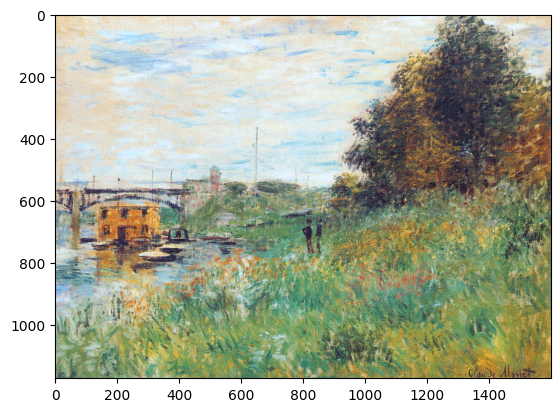

Artist: Sonia Delaunay, Title: Dubonnet, Style: Orphism
File name: 101264.jpg


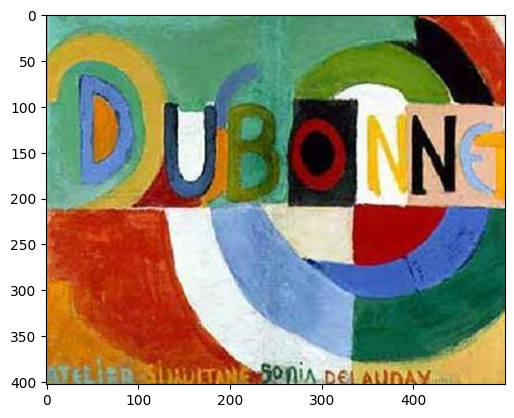

Artist: Buddha II, Title: Saviour's Face: Distant King, Style: Expressionism
File name: 12536.jpg


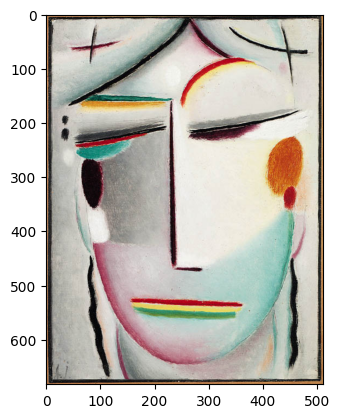

Artist: Sandro Botticelli, Title: Madonna of the Rosegarden, Style: Early Renaissance
File name: 15259.jpg


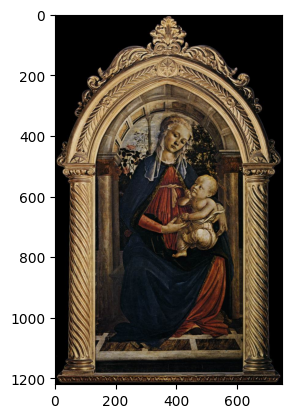

Artist: Jean-Michel Basquiat, Title: Obnoxious Liberals, Style: Neo-Expressionism
File name: 19463.jpg


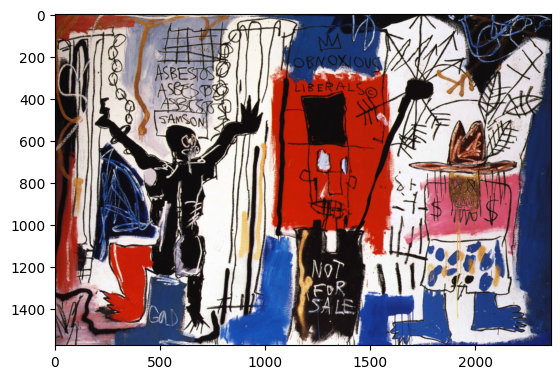

In [4]:
train_1_folder = "/Users/aryan/Downloads/train_1"

for i in range(5):
    img_name = os.listdir(train_1_folder)[i]
    img_path = os.path.join(train_1_folder, img_name)
    img = plt.imread(img_path)
    for j in range(len(df["new_filename"])):
        if df.loc[j, "new_filename"] == img_name:
            print("Artist: {}, Title: {}, Style: {}".format(df.loc[j, "artist"], df.loc[j, "title"], df.loc[j, "style"]))
            plt.imshow(img)
            print("File name:", img_name)
            plt.show()



In [9]:
print(f"The full dataset contains a total of {len(df['artist'].unique())} different artists and {len(df['style'].unique())} unique painting genres.\n")
ash = 5

The full dataset contains a total of 2319 different artists and 137 unique painting genres.



In [28]:
df["style"].value_counts()[0:14]

Impressionism              10643
Realism                    10523
Romanticism                 9285
Expressionism               7013
Post-Impressionism          5778
Art Nouveau (Modern)        4899
Baroque                     4400
Surrealism                  4167
Symbolism                   3476
Rococo                      2733
Northern Renaissance        2379
Naïve Art (Primitivism)     2295
Abstract Expressionism      2074
Neoclassicism               2038
Name: style, dtype: int64

In [32]:
mask = df["style"].value_counts() >= 2000

filtered_df = df.loc[df["style"].isin(mask.index[mask])]
filtered_df


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg
11,Wolfgang Paalen,1937.0,landscape,5331.0,8351.0,1407667.0,wikiart,Surrealism,Forbidden Land,train_only,True,70944.jpg
12,Mabuse,NaN,religious painting,5259.0,8400.0,1489790.0,wikiart,Northern Renaissance,Descent from the cross,train_only,True,59792.jpg
14,Ivan Aivazovsky,1873,marina,7444.0,5811.0,3189597.0,wikiart,Romanticism,Storm at sea,train_and_test,True,99442.jpg
18,Hieronymus Bosch,1515,religious painting,8533.0,4325.0,6675952.0,wikiart,Northern Renaissance,The Garden of Earthly Delights,train_and_test,True,82352.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103232,Henrique Pousao,1882.0,cityscape,516.0,291.0,47079.0,wikiart,Impressionism,"Miragem, Nápoles",train_and_test,True,24316.jpg
103238,Clarence Holbrook Carter,1978.0,abstract,330.0,455.0,36165.0,wikiart,Abstract Expressionism,Tulip,train_and_test,True,9400.jpg
103244,Anne Ryan,1954.0,NaN,534.0,281.0,54145.0,wikiart,Abstract Expressionism,Number 547,train_only,True,23862.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
